In [1]:
import numpy as np
import pandas as pd
import pylab as pl 
import time
import keras
import copy
import random
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import matplotlib.colors as mcolors
from sklearn import preprocessing,metrics,neighbors,mixture,tree, random_projection
from sklearn.metrics import accuracy_score,confusion_matrix,silhouette_score
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score,KFold
from scipy.stats import kurtosis, skew,kurtosistest
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectFromModel
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.decomposition import FastICA, PCA
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Data Preprocessing 

##### Appliances Energy Dataset 

Number of responses
 0    10744
1     8991
Name: energy_high, dtype: int64


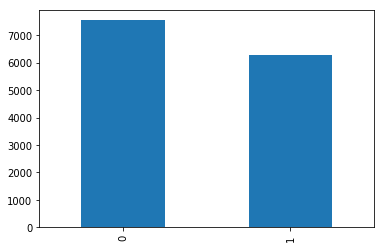

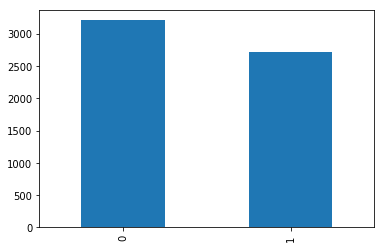

shape of train data:  (13814, 27)


In [2]:
#Appliances Energy Dataset
df = pd.read_csv('energydata_complete.csv')

df = df.drop(columns = ['date'])

df['energy_high'] = np.where(df.Appliances > df.Appliances.median(),1,0)
df['energy_high'] = np.where(df.Appliances > df.Appliances.median(),1,0)

cat = df['energy_high']
df1 = df.drop(columns=['energy_high'])
df1 = (df1-df1.mean())/(df1.std())
df1 = pd.concat([df1,cat],axis=1)
df1 = df1.drop(columns=['Appliances'])

energy_y = df1['energy_high']
energy_x = df1.drop(columns = ['energy_high'])
print("Number of responses\n",energy_y.value_counts())

energy_xtrain,energy_xtest,energy_ytrain,energy_ytest = train_test_split(energy_x,energy_y,test_size=0.3,random_state=23)
energy_ytrain.value_counts().plot.bar()
plt.show()
energy_ytest.value_counts().plot.bar()
plt.show()
energy_ytrain=list(energy_ytrain)
energy_ytest=list(energy_ytest)
print('shape of train data: ',np.shape(energy_xtrain))

##### German Credit Dataset 

Missing Values =  0
Number of Credits
 1    700
0    300
Name: creditability, dtype: int64


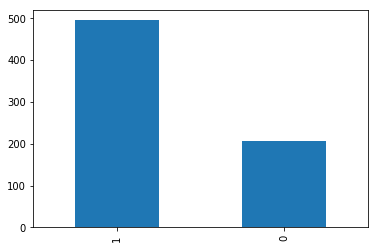

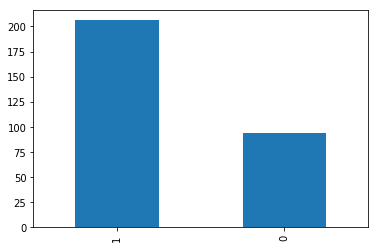

shape of train data:  (700, 61)


In [88]:
# German Credit Dataset
data = pd.read_csv('german_credit.csv',sep = ',')
print("Missing Values = ", data.isnull().values.sum()) #There are no missing values in any of the observations
data = data.rename(columns = {"default":"creditability"})
data1 = data.copy()

#print(data1.head(2))
# 0 = bad credit, 1 = good credit

data1.creditability.replace([0,1], [1,0], inplace=True)
# Number of good credits = 700, Number of bad credits = 300

cont_vars = data1.select_dtypes(include=['int64']).drop(['creditability'],axis=1)
cont_vars = (cont_vars-cont_vars.min())/(cont_vars.max()-cont_vars.min())

data2 = data1.copy()
data3 = cont_vars.copy()

obj_data = data2.select_dtypes(include=['object']).copy()
obj_data = pd.get_dummies(obj_data, prefix=['account', 'credit','purpose','savings','present_since','marital_status','debtors','property','other_plans','housing','job','telephone','foreign'])
#print("obj_data", obj_data.head())

data3 = pd.concat([data1['creditability'],data3],axis=1)
data3.reset_index(drop=True, inplace=True)
obj_data.reset_index(drop=True, inplace=True)
df2 = pd.concat([data3,obj_data], axis=1)
#print("df2", df2.head(2))

credit_y = df2['creditability']
credit_x = df2.drop(columns = ['creditability'])
print("Number of Credits\n",credit_y.value_counts())

credit_xtrain,credit_xtest,credit_ytrain,credit_ytest = train_test_split(credit_x,credit_y,test_size=0.3,random_state=23)
credit_ytrain.value_counts().plot.bar()
plt.show()
credit_ytest.value_counts().plot.bar()
plt.show()
credit_ytrain=list(credit_ytrain)
credit_ytest=list(credit_ytest)
print('shape of train data: ',np.shape(credit_xtrain))

In [100]:
def learning_curves(estimator, title, xtrain, ytrain, ylim=None, cv=10, scoring='accuracy', obj_line=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(estimator, xtrain, ytrain, cv=10, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="red", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="green", label="Cross-validation score")
    if obj_line:
        plt.axhline(y=obj_line, color='blue')
    plt.legend(loc="best")
    return plt

In [96]:
def kmeans(train,minimum,maximum):
    sse,ss={},{}
    for i in range(minimum, maximum):
        kmeans = KMeans(n_clusters=i, random_state=0).fit(train)
        sse[i] = kmeans.inertia_ 
        ss[i] = silhouette_score(train, kmeans.labels_, sample_size=20000, random_state=10)   
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.title("Number of clusters versus SSE")
    plt.show()
    plt.figure()
    plt.plot(list(ss.keys()), list(ss.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("average silhouette_score")
    plt.title("Number of clusters vs average silhouette_score")
    plt.show()
    return None

In [93]:
def em(train,minimum,maximum):
    num = np.arange(minimum, maximum)
    models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(train) for n in num]
    plt.plot(num, [m.aic(train) for m in models], label='AIC')
    plt.plot(num, [m.bic(train) for m in models], label='BIC')
    plt.xlabel('Number of Clusters')
    plt.ylabel('AIC & BIC')
    plt.legend(loc='best')
    plt.show()
    return None

In [85]:
def clusters(clus,y,split):
    #all_colors = [k for k,v in pltc.cnames.items()]
    #colors = sample(all_colors, 20)
    #plt.figure(figsize=(4,4))  
    plt.pie(np.unique(clus,return_counts=True)[1],labels=np.unique(clus,return_counts=True)[0],autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title('Cluster Data Distribution')
    plt.axis('equal')
    plt.show() 
    c=pd.DataFrame(pd.crosstab(clus,y,normalize='index')*100)
    c=c.reset_index()
    c.columns=['Cluster','0','1']
    part1 = plt.bar(c['Cluster'], c['0'],label='0')
    part2 = plt.bar(c['Cluster'], c['1'],bottom=c['0'],label='1')
    plt.axhline(y=split, color='r', linestyle='-')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Count")
    plt.legend(loc='best')
    plt.title('Categories across clusters count')
    plt.show()
    return None

In [7]:
def fun1(xtrain,ytrain,ip_dims,op_dims,parameters,cv):
    def classifier(optimizer,first_hidden_units,second_hidden_units,hidden_activation_fun,output_activation_func):
        c = Sequential()
        c.add(Dense(output_dim = first_hidden_units, init = 'uniform', activation = hidden_activation_fun, input_dim = ip_dims))
        c.add(Dense(output_dim = second_hidden_units, init = 'uniform', activation = hidden_activation_fun))
        c.add(Dense(output_dim = op_dims, init = 'uniform', activation = output_activation_func))
        c.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
        return c
    c = KerasClassifier(build_fn = classifier)
    grid_search = GridSearchCV(estimator = c,param_grid = parameters,scoring = 'accuracy',cv = cv)
    return grid_search
def fun2(xtrain,ytrain,xtest,ytest,ip_dims,op_dims,parameters,cv):
        time_iter = time.time()
        grid_search=fun1(xtrain,ytrain,xtrain.shape[1],op_dims,parameters,cv)
        grid_search = grid_search.fit(xtrain, ytrain)
        cv_acc=np.round(grid_search.cv_results_['mean_test_score'],4)*100
        train_acc=np.round(accuracy_score(grid_search.predict(xtrain),ytrain),4)*100
        test_acc=np.round(accuracy_score(grid_search.predict(xtest),ytest),4)*100
        t=time.time()-time_iter 
        return grid_search,t,cv_acc,train_acc,test_acc

### Clustering 

#### Appliances Energy Dataset

##### KMeans 

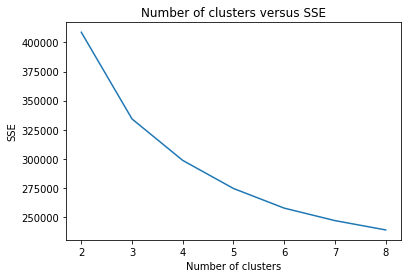

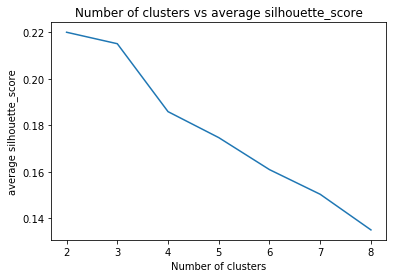

In [8]:
kmeans(energy_x,2,9)

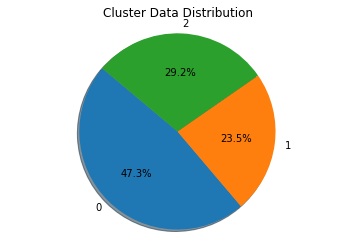

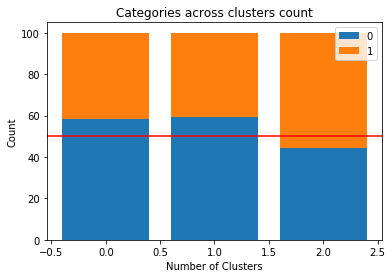

In [25]:
clus = KMeans(n_clusters=3, random_state=0).fit_predict(energy_x)
clusters(clus,energy_y,50)

##### EM

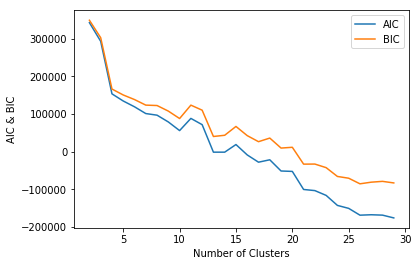

In [21]:
em(energy_x,2,30)

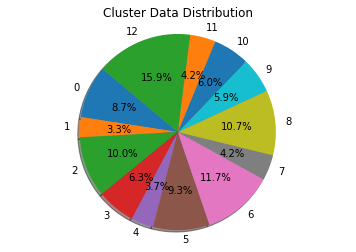

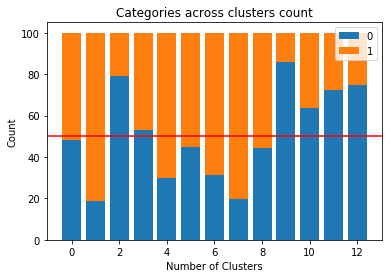

In [103]:
gauss = GaussianMixture(13, covariance_type='full', random_state=0).fit(energy_x)
clus = gauss.predict(energy_x)
clusters(clus,energy_y,50)

#### German Credit Dataset 

##### KMeans 

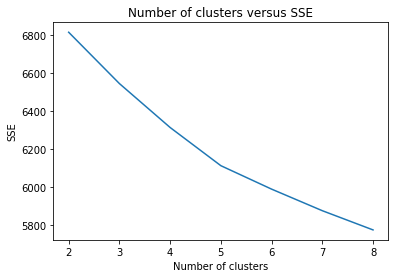

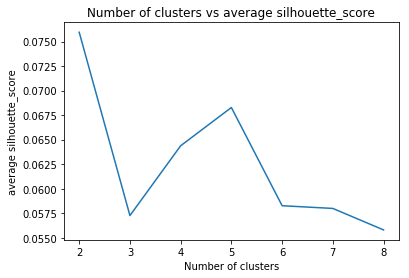

In [97]:
kmeans(credit_x,2,9)

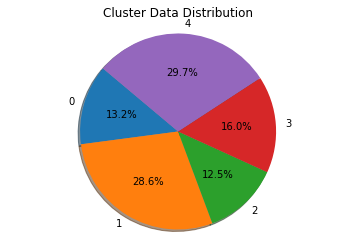

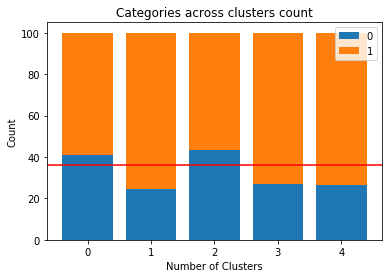

In [86]:
clus = KMeans(n_clusters=5, random_state=0).fit_predict(credit_x)
clusters(clus,credit_y,36)

##### EM 

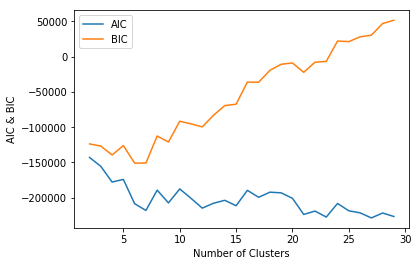

In [94]:
em(credit_x,2,30)

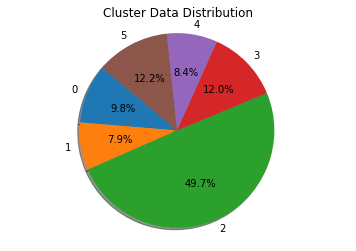

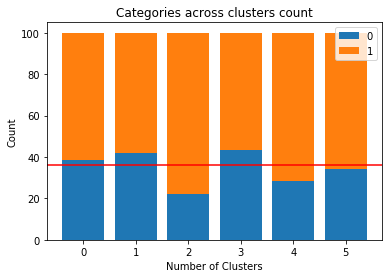

In [29]:
gmm = GaussianMixture(6, covariance_type='full', random_state=0).fit(credit_x)
clus = gmm.predict(credit_x)
clusters(clus,credit_y,36)

### Feature Selection

#### Appliances Energy Dataset 

Before transformation: (19735, 27)
After transformation: (19735, 11)
columns: Index(['lights', 'RH_1', 'T2', 'RH_5', 'T6', 'RH_6', 'T8', 'RH_8', 'RH_9',
       'Press_mm_hg', 'RH_out'],
      dtype='object')


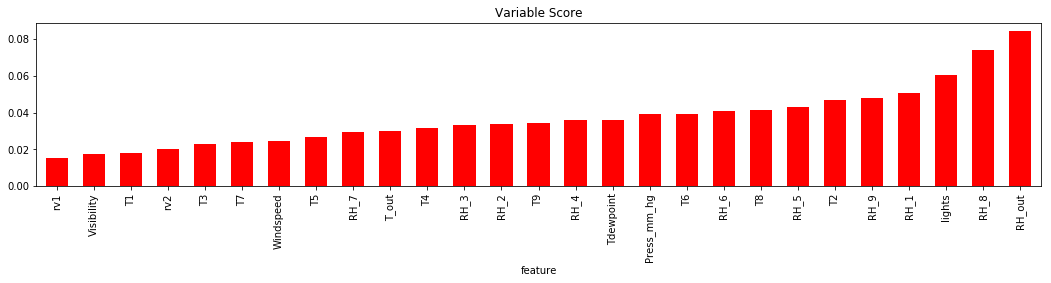

In [103]:
energy_y_copy=energy_y.astype('int')
dt = tree.DecisionTreeClassifier(random_state=0,criterion="entropy")
dt.fit(energy_x,energy_y_copy)
print("Before transformation:",energy_x.shape)
dt.feature_importances_  
model = SelectFromModel(dt, prefit=True)
energy_x_dt = model.transform(energy_x)
print("After transformation:",energy_x_dt.shape )
print("columns:",energy_x.columns[model.get_support()])
features=pd.concat([pd.DataFrame(energy_x.columns),pd.DataFrame(dt.feature_importances_)],axis=1)
features.columns=['feature','imp']
features.sort_values(by=['imp'],inplace=True)
features.set_index('feature',inplace=True)
plt.figure(figsize=(18,3))
features['imp'].plot.bar(width=0.6,color='r')
plt.title('Variable Score')
plt.show()

#### German Credit Dataset 

Before transformation: (1000, 61)
After transformation: (1000, 18)
columns: Index(['duration_in_month', 'credit_amount', 'installment_as_income_perc',
       'age', 'account_< 0 DM', 'account_no checking account',
       'credit_all credits at this bank paid back duly', 'purpose_car (used)',
       'purpose_domestic appliances', 'purpose_radio/television',
       'savings_... < 100 DM', 'savings_100 <= ... < 500 DM',
       'present_since_4 <= ... < 7 years',
       'property_if not A121/A122 : car or other, not in attribute 6',
       'other_plans_none', 'housing_rent', 'job_skilled employee / official',
       'telephone_none'],
      dtype='object')


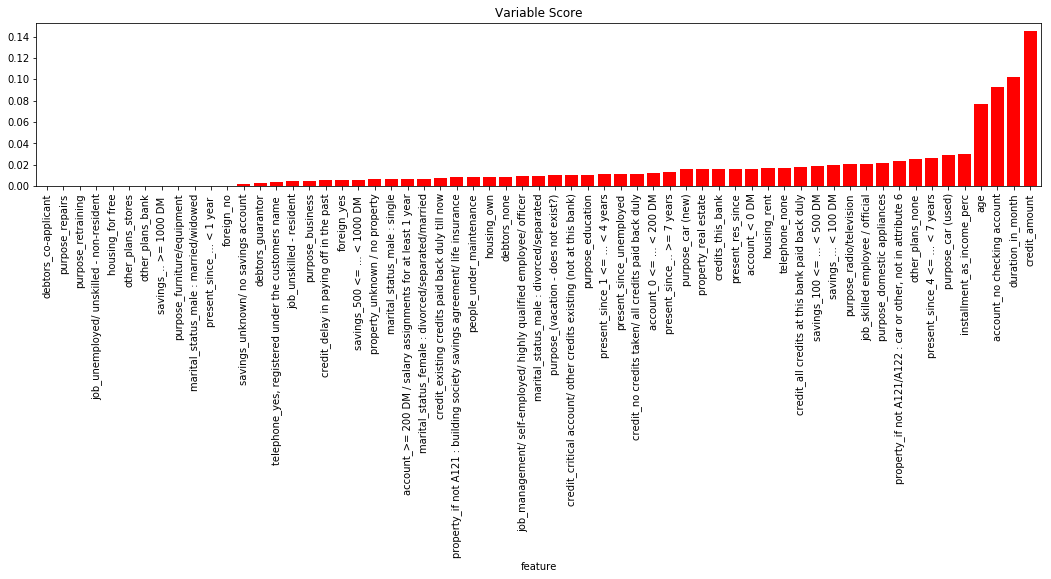

In [102]:
credit_y_copy=credit_y.astype('int')
dt = tree.DecisionTreeClassifier(random_state=0,criterion="entropy")
dt.fit(credit_x,credit_y_copy)
print("Before transformation:",credit_x.shape)
dt.feature_importances_  
model = SelectFromModel(dt, prefit=True)
credit_x_dt = model.transform(credit_x)
print("After transformation:",credit_x_dt.shape )
print("columns:",credit_x.columns[model.get_support()])
features=pd.concat([pd.DataFrame(credit_x.columns),pd.DataFrame(dt.feature_importances_)],axis=1)
features.columns=['feature','imp']
features.sort_values(by=['imp'],inplace=True)
features.set_index('feature',inplace=True)
plt.figure(figsize=(18,3))
features['imp'].plot.bar(width=0.8,color='r')
plt.title('Variable Score')
plt.show()

### PCA 

#### Appliances Energy Dataset 

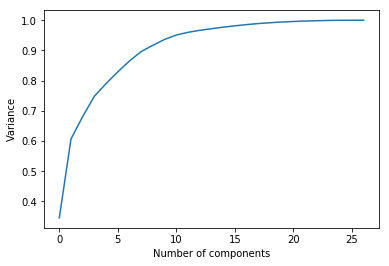

Before transformation: (19735, 27)
Number of features after PCA: (19735, 9)


In [25]:
pca = PCA().fit(energy_x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance')
plt.show()
pca = PCA(0.90).fit(energy_x)
energy_x_pca=pca.transform(energy_x)
print("Before transformation:", energy_x.shape)
print("Number of features after PCA:", energy_x_pca.shape)

#### German Credit Dataset 

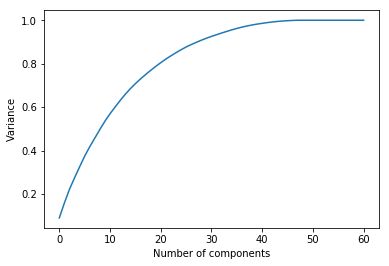

Before Transformation: (1000, 61)
Number of features after PCA: (1000, 29)


In [26]:
pca = PCA().fit(credit_x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance')
plt.show()
pca = PCA(0.90).fit(credit_x)
credit_x_pca=pca.transform(credit_x)
print("Before Transformation:", credit_x.shape)
print("Number of features after PCA:", credit_x_pca.shape)

### ICA 

#### Appliances Energy Dataset 

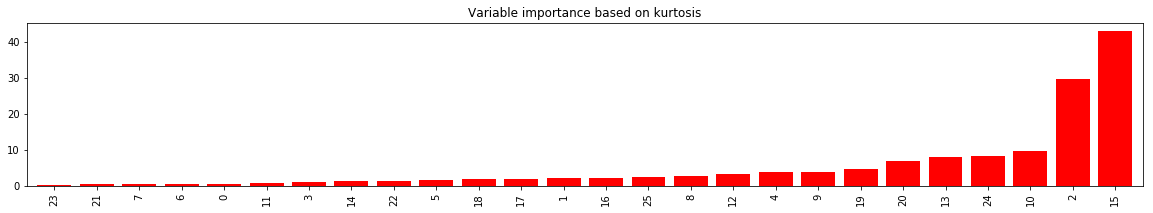

Number of features after reduction (19735, 6)


In [104]:
ica = FastICA(random_state=0)
energy_x_ica = ica.fit_transform(energy_x)
k,index=[],[]
for i in range(1, energy_x_ica.shape[1]):
    k.append(abs(kurtosis(energy_x_ica[:,i], fisher=True)))
    index.append(i)
kdata=pd.DataFrame(k,index)
kdata.reset_index(inplace=True)
kdata.columns=['index','kurtosis']
kdata=kdata.sort_values(['kurtosis'],ascending=[1])
plt.figure(figsize=(20, 3))
kdata['kurtosis'].plot.bar(width=0.8,color='r')
plt.title('Variable importance based on kurtosis')
plt.show()
energy_x_ica=energy_x_ica[:,kdata[kdata['kurtosis']<=1]['index']]
print("Number of features after reduction",energy_x_ica.shape)

#### German Credit Dataset 

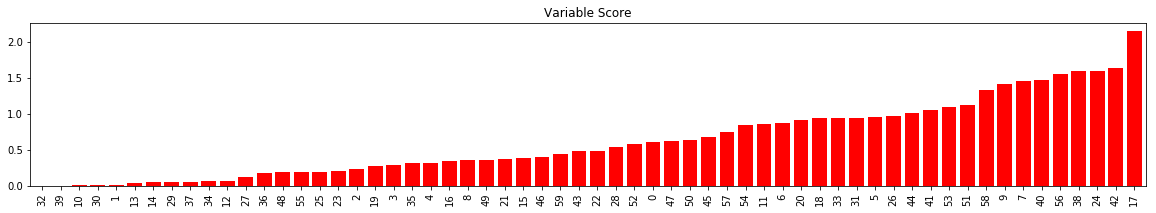

Number of features after ICA (1000, 47)


In [105]:
ica = FastICA(random_state=0)
credit_x_ica = ica.fit_transform(credit_x)
k,index=[],[]
for i in range(1, credit_x_ica.shape[1]):
    k.append(abs(kurtosis(credit_x_ica[:,i], fisher=True)))
    index.append(i)
kdata=pd.DataFrame(k,index)
kdata.reset_index(inplace=True)
kdata.columns=['index','kurtosis']
kdata=kdata.sort_values(['kurtosis'],ascending=[1])
plt.figure(figsize=(20, 3))
kdata['kurtosis'].plot.bar(width=0.8,color='r')
plt.title('Variable Score')
plt.show()
credit_x_ica=credit_x_ica[:,kdata[kdata['kurtosis']<=1]['index']]
print("Number of features after ICA",credit_x_ica.shape)

### Random Projections 

In [29]:
def ra(data, original_dim, new_dim):
    rows,mm,o = len(data),0.1,0.9
    m = np.empty((original_dim, new_dim))
    for i in range(len(m)):
        for j in range(len(m[i])):
            rand = random.random()
            if rand < mm:m[i][j] = -1
            elif rand >= o:m[i][j] = 1
            else:m[i][j] = 0
    new = np.mat(data) * m
    return new,m

#### Appliances Energy Dataset 

In [30]:
energy_x_ra,m=ra(energy_x, energy_x.shape[1], int(energy_x.shape[1]/2))
print("After RA:",energy_x_ra.shape)

After RA: (19735, 13)


#### German Credit Dataset 

In [31]:
credit_x_ra,m=ra(credit_x, credit_x.shape[1], int(credit_x.shape[1]/2))
print("After RA:",credit_x_ra.shape)

After RA: (1000, 30)


In [32]:
energy_x_dt = pd.DataFrame(energy_x_dt)
energy_x_pca = pd.DataFrame(energy_x_pca)
energy_x_ica = pd.DataFrame(energy_x_ica)
energy_x_ra = pd.DataFrame(energy_x_ra)
credit_x_dt = pd.DataFrame(credit_x_dt)
credit_x_pca = pd.DataFrame(credit_x_pca)
credit_x_ica = pd.DataFrame(credit_x_ica)
credit_x_ra = pd.DataFrame(credit_x_ra)

### Clustering after Dimensionality Reductiom

#### Decision Trees

##### Appliances Energy Dataset 

##### K-Means 

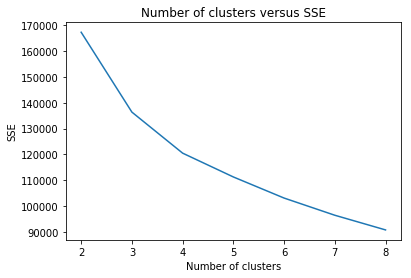

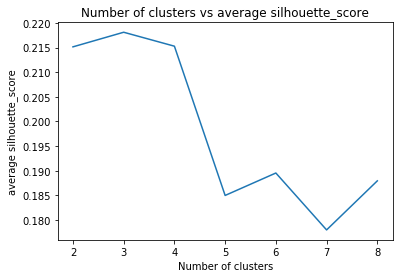

In [23]:
kmeans(energy_x_dt,2,9)

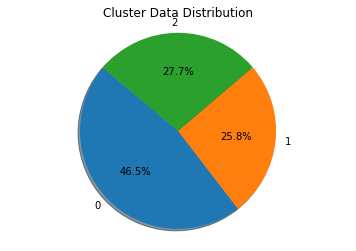

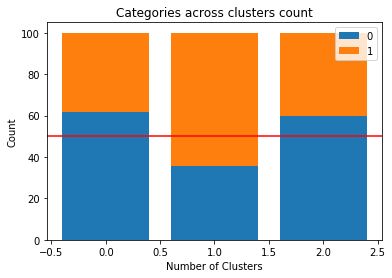

In [24]:
clus = KMeans(n_clusters=3, random_state=0).fit_predict(energy_x_dt)
clusters(clus,energy_y,50)

##### EM

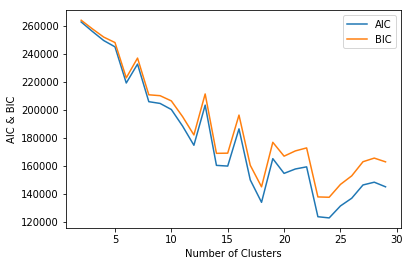

In [33]:
em(energy_x_dt,2,30)

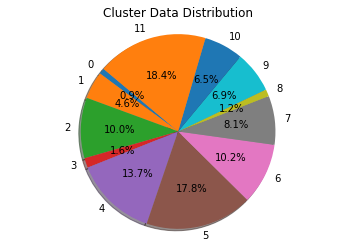

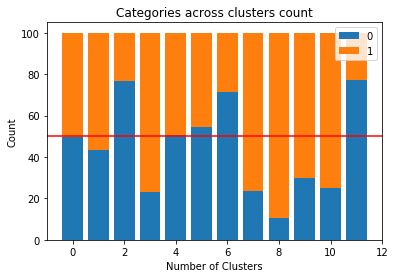

In [31]:
gmm = GaussianMixture(12, covariance_type='full', random_state=0).fit(energy_x_dt)
clus = gmm.predict(energy_x_dt)
clusters(clus,energy_y,50)

##### German Credit Dataset 

##### K-Means 

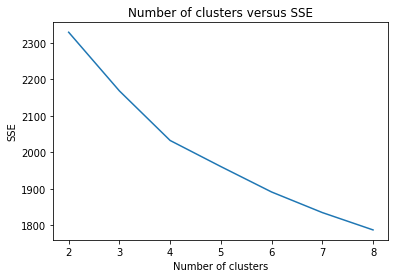

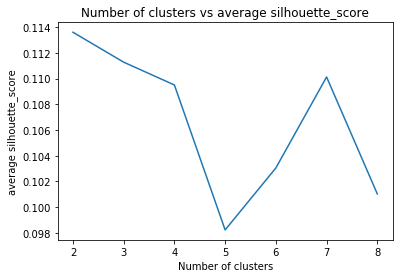

In [32]:
kmeans(credit_x_dt,2,9)

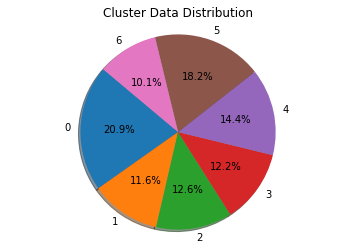

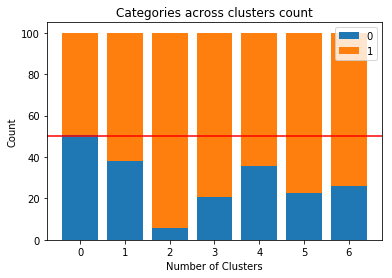

In [33]:
clus = KMeans(n_clusters=7, random_state=0).fit_predict(credit_x_dt)
clusters(clus,credit_y,50)

##### EM

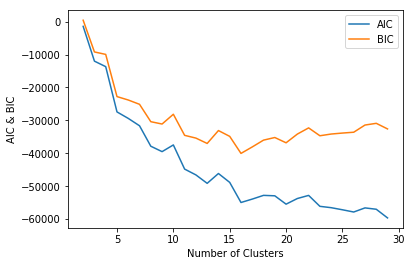

In [34]:
em(credit_x_dt,2,30)

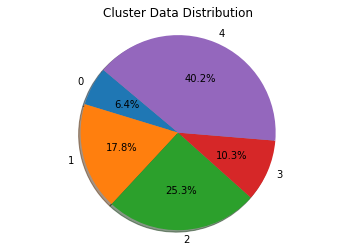

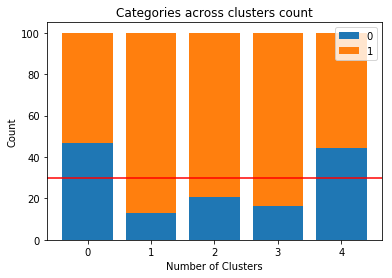

In [35]:
gmm = GaussianMixture(5, covariance_type='full', random_state=0).fit(credit_x_dt)
clus = gmm.predict(credit_x_dt)
clusters(clus,credit_y,30)

#### PCA

##### Appliances Energy Dataset

##### KMeans

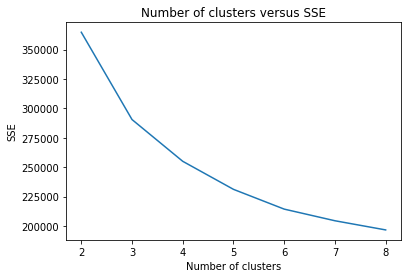

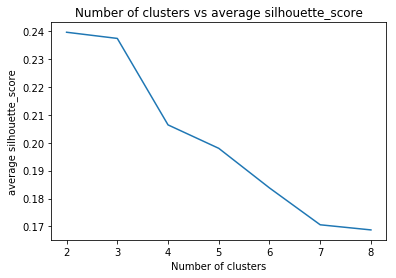

In [36]:
kmeans(energy_x_pca,2,9)

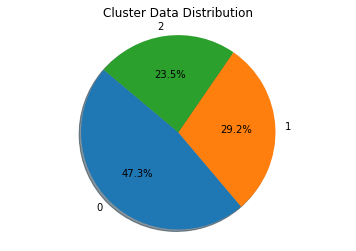

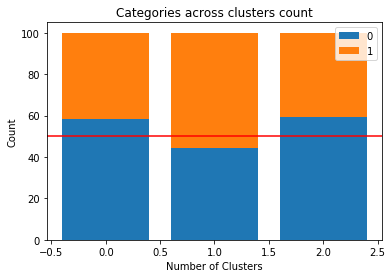

In [37]:
clus = KMeans(n_clusters=3, random_state=0).fit_predict(energy_x_pca)
clusters(clus,energy_y,50)

##### EM

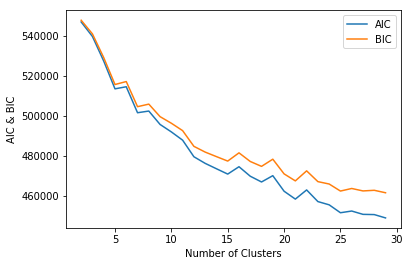

In [35]:
em(energy_x_pca,2,30)

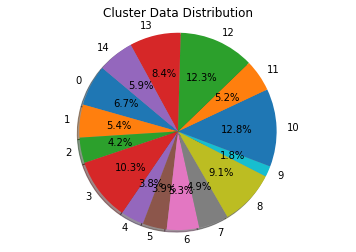

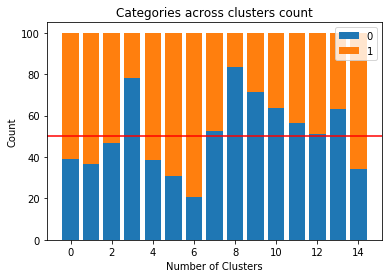

In [39]:
gmm = GaussianMixture(15, covariance_type='full', random_state=0).fit(energy_x_pca)
clus = gmm.predict(energy_x_pca)
clusters(clus,energy_y,50)

##### German Credit Dataset

##### KMeans

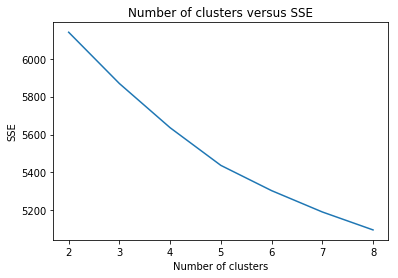

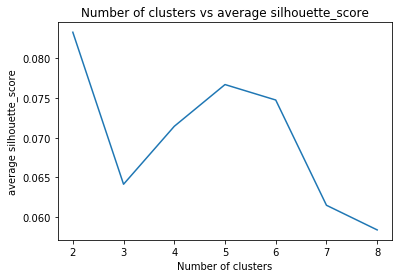

In [40]:
kmeans(credit_x_pca,2,9)

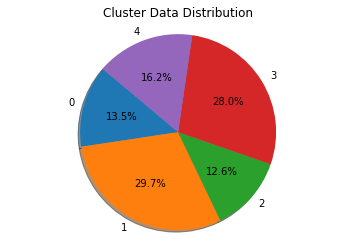

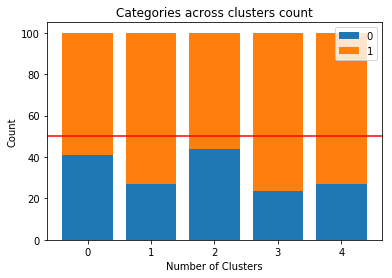

In [41]:
clus = KMeans(n_clusters=5, random_state=0).fit_predict(credit_x_pca)
clusters(clus,credit_y,50)

##### EM

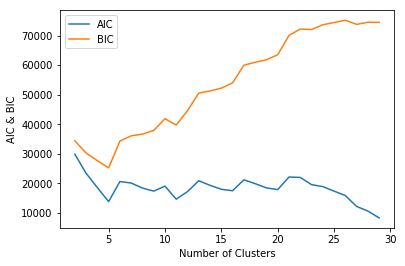

In [36]:
em(credit_x_pca,2,30)

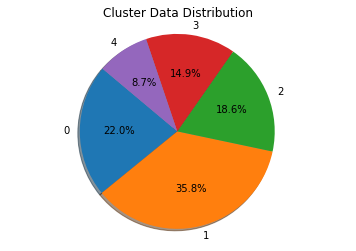

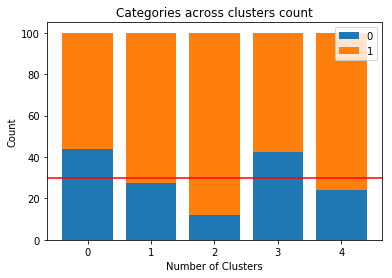

In [43]:
gmm = GaussianMixture(5, covariance_type='full', random_state=0).fit(credit_x_pca)
clus = gmm.predict(credit_x_pca)
clusters(clus,credit_y,30)

#### ICA

##### Appliances Energy Dataset

##### KMeans

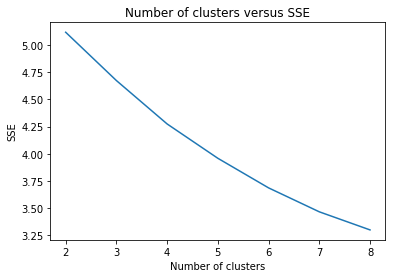

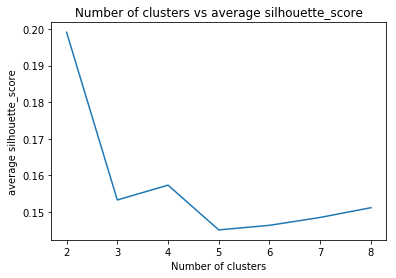

In [44]:
kmeans(energy_x_ica,2,9)

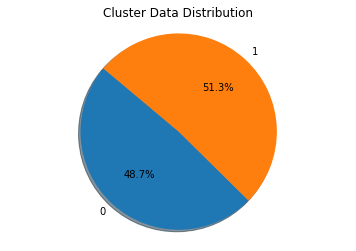

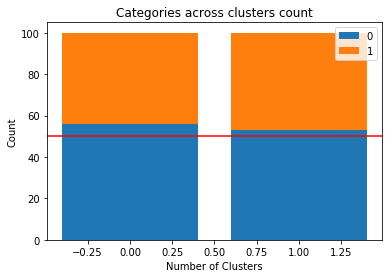

In [45]:
clus = KMeans(n_clusters=2, random_state=0).fit_predict(energy_x_ica)
clusters(clus,energy_y,50)

##### EM

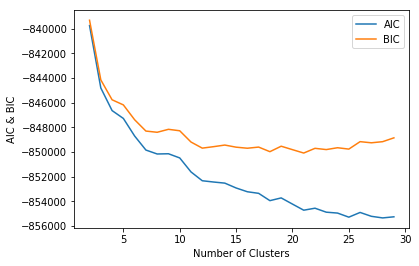

In [37]:
em(energy_x_ica,2,30)

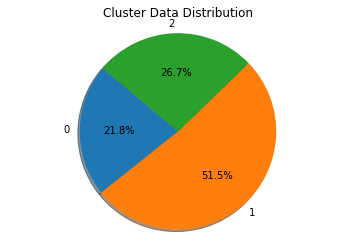

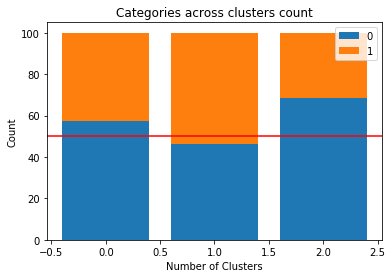

In [49]:
gmm = GaussianMixture(3, covariance_type='full', random_state=0).fit(energy_x_ica)
clus = gmm.predict(energy_x_ica)
clusters(clus,energy_y,50)

##### German Credit Dataset

##### KMeans

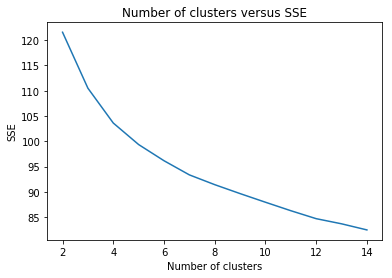

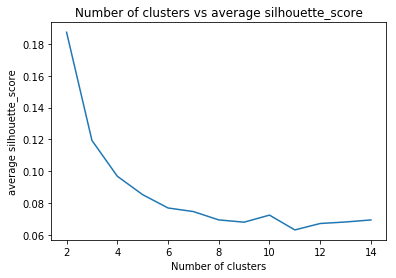

In [56]:
kmeans(credit_x_ica,2,15)

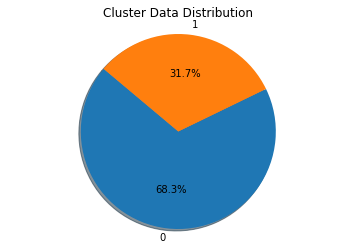

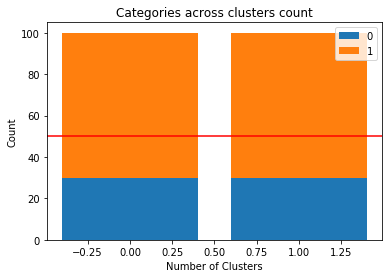

In [57]:
clus = KMeans(n_clusters=2, random_state=0).fit_predict(credit_x_ica)
clusters(clus,credit_y,50)

##### EM

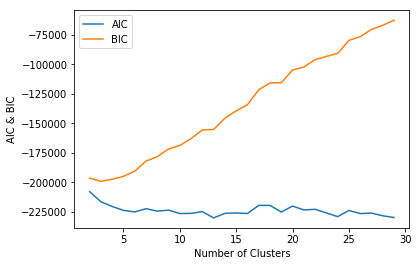

In [38]:
em(credit_x_ica,2,30)

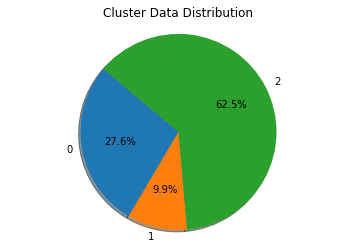

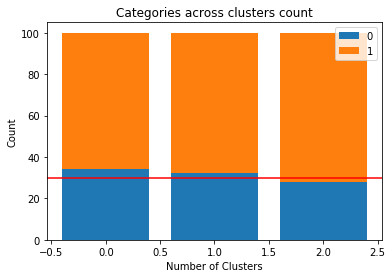

In [60]:
gmm = GaussianMixture(3, covariance_type='full', random_state=0).fit(credit_x_ica)
clus = gmm.predict(credit_x_ica)
clusters(clus,credit_y,30)

#### Random Projections 

##### Appliances Energy Dataset

##### KMeans

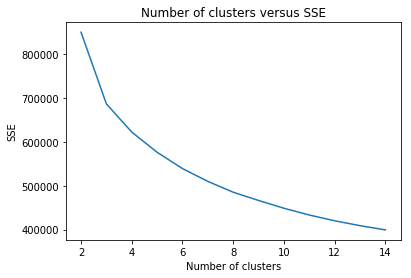

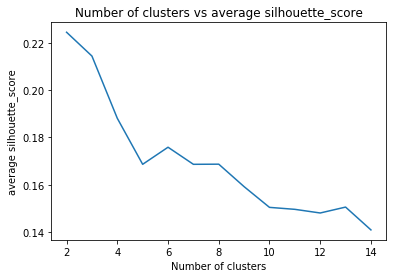

In [61]:
kmeans(energy_x_ra,2,15)

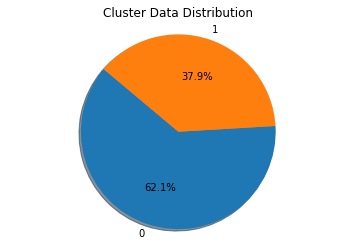

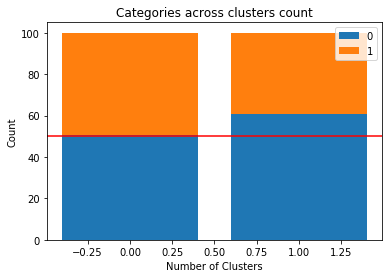

In [62]:
clus = KMeans(n_clusters=2, random_state=0).fit_predict(energy_x_ra)
clusters(clus,energy_y,50)

##### EM

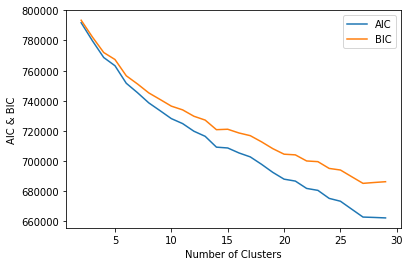

In [39]:
em(energy_x_ra,2,30)

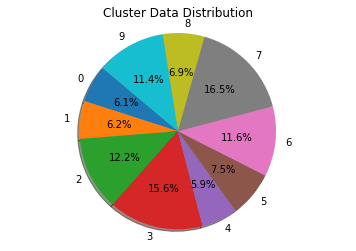

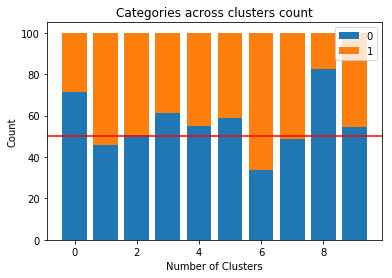

In [64]:
gmm = GaussianMixture(10, covariance_type='full', random_state=0).fit(energy_x_ra)
clus = gmm.predict(energy_x_ra)
clusters(clus,energy_y,50)

##### German Credit Dataset

##### KMeans

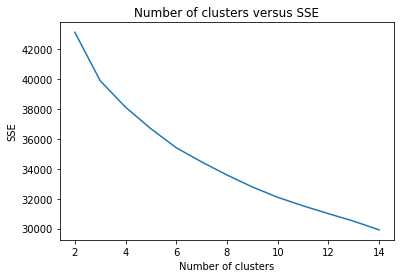

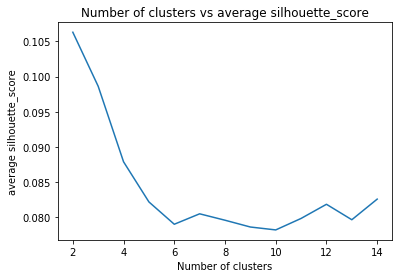

In [65]:
kmeans(credit_x_ra,2,15)

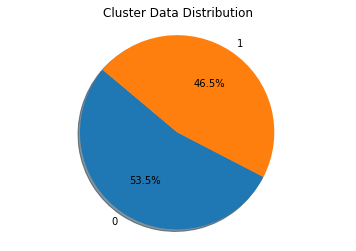

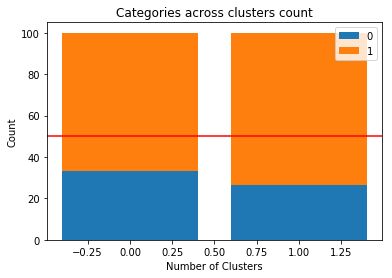

In [66]:
clus = KMeans(n_clusters=2, random_state=0).fit_predict(credit_x_ra)
clusters(clus,credit_y,50)

##### EM

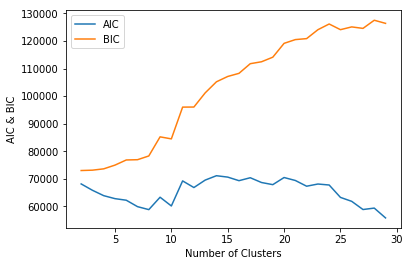

In [40]:
em(credit_x_ra,2,30)

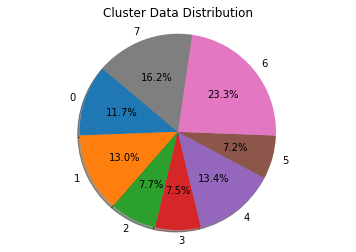

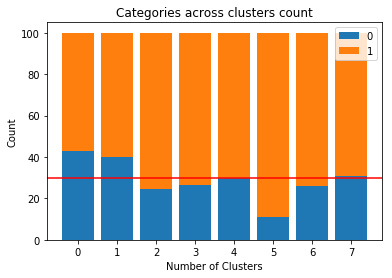

In [41]:
gmm = GaussianMixture(8, covariance_type='full', random_state=0).fit(credit_x_ra)
clus = gmm.predict(credit_x_ra)
clusters(clus,credit_y,30)

In [108]:
def test_train_split(energy_x_dt, energy_y):
    energy_xtrain_dt,energy_xtest_dt,energy_ytrain_dt,energy_ytest_dt = train_test_split(energy_x_dt,energy_y,test_size=0.3,random_state=23)
    energy_ytrain_dt = list(energy_ytrain_dt)
    energy_ytest_dt = list(energy_ytest_dt)
    return energy_xtrain_dt,energy_xtest_dt,energy_ytrain_dt,energy_ytest_dt

In [109]:
energy_xtrain_dt,energy_xtest_dt,energy_ytrain_dt,energy_ytest_dt = test_train_split(energy_x_dt,energy_y)
energy_xtrain_pca,energy_xtest_pca,energy_ytrain_pca,energy_ytest_pca = test_train_split(energy_x_pca,energy_y)
energy_xtrain_ica,energy_xtest_ica,energy_ytrain_ica,energy_ytest_ica = test_train_split(energy_x_ica,energy_y)
energy_xtrain_ra,energy_xtest_ra,energy_ytrain_ra,energy_ytest_ra = test_train_split(energy_x_ra,energy_y)

credit_xtrain_dt,credit_xtest_dt,credit_ytrain_dt,credit_ytest_dt = test_train_split(credit_x_dt,credit_y)
credit_xtrain_pca,credit_xtest_pca,credit_ytrain_pca,credit_ytest_pca = test_train_split(credit_x_pca,credit_y)
credit_xtrain_ica,credit_xtest_ica,credit_ytrain_ica,credit_ytest_ica = test_train_split(credit_x_ica,credit_y)
credit_xtrain_ra,credit_xtest_ra,credit_ytrain_ra,credit_ytest_ra = test_train_split(credit_x_ra,credit_y)

### Neural Networks

#### Appliances Energy Dataset 

Epoch 1/10
9209/9209 [==============================] - 0s 48us/step - loss: 0.6479 - accuracy: 0.6642
Epoch 2/10
9209/9209 [==============================] - 0s 34us/step - loss: 0.5300 - accuracy: 0.7423
Epoch 3/10
9209/9209 [==============================] - 0s 33us/step - loss: 0.4986 - accuracy: 0.7599
Epoch 4/10
9209/9209 [==============================] - 0s 34us/step - loss: 0.4858 - accuracy: 0.7695
Epoch 5/10
9209/9209 [==============================] - 0s 31us/step - loss: 0.4757 - accuracy: 0.7828
Epoch 6/10
9209/9209 [==============================] - 0s 35us/step - loss: 0.4698 - accuracy: 0.7840
Epoch 7/10
9209/9209 [==============================] - 0s 33us/step - loss: 0.4642 - accuracy: 0.7891
Epoch 8/10
9209/9209 [==============================] - 0s 28us/step - loss: 0.4597 - accuracy: 0.7907
Epoch 9/10
9209/9209 [==============================] - 0s 33us/step - loss: 0.4560 - accuracy: 0.7960
Epoch 10/10
9209/9209 [==============================] - 0s 33us/step - l

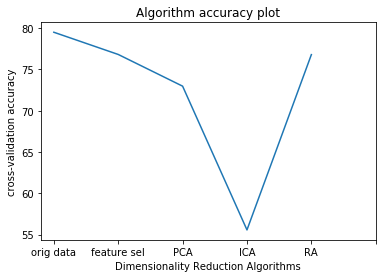

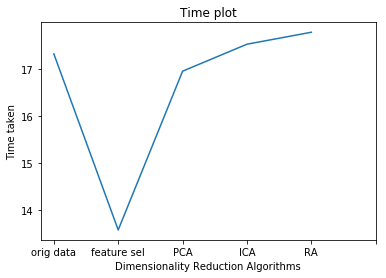

In [111]:
param = {'batch_size': [64],'optimizer': ['Adam'],'epochs': [10],'first_hidden_units':[20],'second_hidden_units':[10],'hidden_activation_fun':['relu'],'output_activation_func':['sigmoid']}

energy_grid_org,energy_times_org,energy_cvacc_org,energy_train_acc_org,energy_test_acc_org=fun2(energy_xtrain,energy_ytrain,energy_xtest,energy_ytest,energy_xtrain.shape[1],1,param,3)
energy_grid_dt,energy_times_dt,energy_cvacc_dt,energy_train_acc_dt,energy_test_acc_dt=fun2(energy_xtrain_dt,energy_ytrain_dt,energy_xtest_dt,energy_ytest_dt,energy_xtrain_dt.shape[1],1,param,3)
energy_grid_pca,energy_times_pca,energy_cvacc_pca,energy_train_acc_pca,energy_test_acc_pca=fun2(energy_xtrain_pca,energy_ytrain_pca,energy_xtest_pca,energy_ytest_pca,energy_xtrain_pca.shape[1],1,param,3)
energy_vary_grid_ica,energy_times_ica,energy_cvacc_ica,energy_train_acc_ica,energy_test_acc_ica=fun2(energy_xtrain_ica,energy_ytrain_ica,energy_xtest_ica,energy_ytest_ica,energy_xtrain_ica.shape[1],1,param,3)
energy_grid_ra,energy_times_ra,energy_cvacc_ra,energy_train_acc_ra,energy_test_acc_ra=fun2(energy_xtrain_ra,energy_ytrain_ra,energy_xtest_ra,energy_ytest_ra ,energy_xtrain_ra.shape[1],1,param,3)

x = np.array(["orig data","feature sel","PCA","ICA","RA"])
cv_acc = np.array([energy_cvacc_org,energy_cvacc_dt,energy_cvacc_pca,energy_cvacc_ica,energy_cvacc_ra])
plt.plot(cv_acc)
plt.xticks([0,1,2,3,4,5], x)
plt.xlabel('Dimensionality Reduction Algorithms')
plt.ylabel('cross-validation accuracy')
plt.title('Algorithm accuracy plot')
plt.show()

y = np.array(["orig data","feature sel","PCA","ICA","RA"])
cv_acc = np.array([energy_times_org,energy_times_dt,energy_times_pca,energy_times_ica,energy_times_ra])
plt.plot(cv_acc)
plt.xticks([0,1,2,3,4,5], y)
plt.xlabel('Dimensionality Reduction Algorithms')
plt.ylabel('Time taken')
plt.title('Time plot')
plt.show()

#### German Credit Dataset 

Epoch 1/10
466/466 [==============================] - 0s 227us/step - loss: 0.6908 - accuracy: 0.6867
Epoch 2/10
466/466 [==============================] - 0s 32us/step - loss: 0.6828 - accuracy: 0.7039
Epoch 3/10
466/466 [==============================] - 0s 32us/step - loss: 0.6588 - accuracy: 0.7039
Epoch 4/10
466/466 [==============================] - 0s 41us/step - loss: 0.6186 - accuracy: 0.7039
Epoch 5/10
466/466 [==============================] - 0s 43us/step - loss: 0.5874 - accuracy: 0.7039
Epoch 6/10
466/466 [==============================] - 0s 45us/step - loss: 0.5788 - accuracy: 0.7039
Epoch 7/10
466/466 [==============================] - 0s 41us/step - loss: 0.5607 - accuracy: 0.7039
Epoch 8/10
466/466 [==============================] - 0s 47us/step - loss: 0.5444 - accuracy: 0.7039
Epoch 9/10
466/466 [==============================] - 0s 41us/step - loss: 0.5241 - accuracy: 0.7039
Epoch 10/10
466/466 [==============================] - 0s 49us/step - loss: 0.5064 - accur

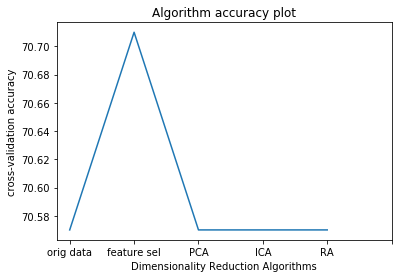

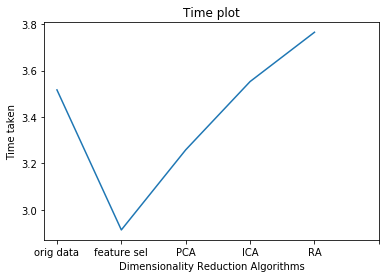

In [101]:
parameters = param = {'batch_size': [32],'epochs': [10],'optimizer': ['adam'],'first_hidden_units':[30],'second_hidden_units':[15],'hidden_activation_fun':['relu'],'output_activation_func':['sigmoid']}

credit_grid_org,credit_times_org,credit_cvacc_org,energy_train_acc_org,energy_test_acc_org=fun2(credit_xtrain,credit_ytrain,credit_xtest,credit_ytest,credit_xtrain.shape[1],1,parameters,3)
credit_grid_dt,credit_times_dt,credit_cvacc_dt,credit_train_acc_dt,credit_test_acc_dt=fun2(credit_xtrain_dt,credit_ytrain_dt,credit_xtest_dt,credit_ytest_dt,credit_xtrain_dt.shape[1],1,parameters,3)
credit_grid_pca,credit_times_pca,credit_cvacc_pca,credit_train_acc_pca,credit_test_acc_pca=fun2(credit_xtrain_pca,credit_ytrain_pca,credit_xtest_pca,credit_ytest_pca,credit_xtrain_pca.shape[1],1,parameters,3)
credit_vary_grid_ica,credit_times_ica,credit_cvacc_ica,credit_train_acc_ica,credit_test_acc_ica=fun2(credit_xtrain_ica,credit_ytrain_ica,credit_xtest_ica,credit_ytest_ica,credit_xtrain_ica.shape[1],1,parameters,3)
credit_grid_ra,credit_times_ra,credit_cvacc_ra,credit_train_acc_ra,credit_test_acc_ra=fun2(credit_xtrain_ra,credit_ytrain_ra,credit_xtest_ra,credit_ytest_ra,credit_xtrain_ra.shape[1],1,parameters,3)

x = np.array(["orig data","feature sel","PCA","ICA","RA"])
cv_acc = np.array([credit_cvacc_org,credit_cvacc_dt,credit_cvacc_pca,credit_cvacc_ica,credit_cvacc_ra])
plt.plot(cv_acc)
plt.xticks([0,1,2,3,4,5], x)
plt.xlabel('Dimensionality Reduction Algorithms')
plt.ylabel('cross-validation accuracy')
plt.title('Algorithm accuracy plot')
plt.show()

y = np.array(["orig data","feature sel","PCA","ICA","RA"])
cv_acc = np.array([credit_times_org,credit_times_dt,credit_times_pca,credit_times_ica,credit_times_ra])
plt.plot(cv_acc)
plt.xticks([0,1,2,3,4,5], y)
plt.xlabel('Dimensionality Reduction Algorithms')
plt.ylabel('Time taken')
plt.title('Time plot')
plt.show()

### Cluster Data with Neural Networks

#### Appliances Energy Dataset 

Shape of the Cluster: (19735, 14)
Epoch 1/10
9209/9209 [==============================] - 1s 93us/step - loss: 0.6433 - accuracy: 0.6289
Epoch 2/10
9209/9209 [==============================] - 1s 71us/step - loss: 0.6020 - accuracy: 0.6712
Epoch 3/10
9209/9209 [==============================] - 1s 70us/step - loss: 0.6008 - accuracy: 0.6758
Epoch 4/10
9209/9209 [==============================] - 1s 71us/step - loss: 0.5994 - accuracy: 0.6742
Epoch 5/10
9209/9209 [==============================] - 1s 70us/step - loss: 0.5996 - accuracy: 0.6758
Epoch 6/10
9209/9209 [==============================] - 1s 71us/step - loss: 0.5988 - accuracy: 0.6749
Epoch 7/10
9209/9209 [==============================] - 1s 79us/step - loss: 0.5985 - accuracy: 0.6739
Epoch 8/10
9209/9209 [==============================] - 1s 69us/step - loss: 0.5975 - accuracy: 0.6712
Epoch 9/10
9209/9209 [==============================] - 1s 66us/step - loss: 0.5976 - accuracy: 0.6764
Epoch 10/10
9209/9209 [================

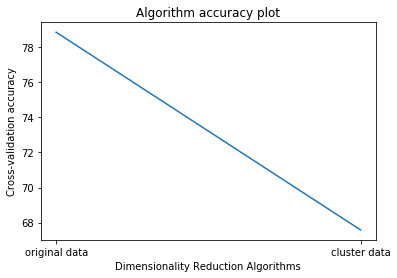

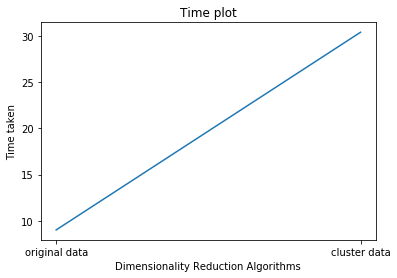

In [108]:
k = KMeans(n_clusters=3, random_state=0).fit_predict(energy_x)
g = GaussianMixture(13, covariance_type='full', random_state=0).fit(energy_x)
g_pred = g.predict_proba(energy_x)
cluster1=pd.DataFrame(g_pred)
cluster1['k']=pd.DataFrame(k)
print('Shape of the Cluster:',cluster1.shape)

clus_xtrain, clus_xtest, clus_ytrain, clus_ytest = test_train_split(cluster1, energy_y)
energy_grid_clus,energy_times_clus,energy_cvacc_clus,energy_train_acc_clus,energy_test_acc_clus = fun2(clus_xtrain,clus_ytrain,clus_xtest,clus_ytest,clus_xtrain.shape[1],1,param,3)

x = np.array(["original data","cluster data"])
cv_acc = np.array([energy_cvacc_org,energy_cvacc_clus])
plt.plot(cv_acc)
plt.xticks([0,1],x)
plt.xlabel('Dimensionality Reduction Algorithms')
plt.ylabel('Cross-validation accuracy')
plt.title('Algorithm accuracy plot')
plt.show()

cv_acc = np.array([energy_times_org,energy_times_clus])
plt.plot(cv_acc)
plt.xticks([0,1], x)
plt.xlabel('Dimensionality Reduction Algorithms')
plt.ylabel('Time taken')
plt.title('Time plot')
plt.show()

#### German Credit Dataset 

Shape of the Cluster: (1000, 7)
Epoch 1/10
466/466 [==============================] - 0s 432us/step - loss: 0.6911 - accuracy: 0.6845
Epoch 2/10
466/466 [==============================] - 0s 39us/step - loss: 0.6848 - accuracy: 0.7039
Epoch 3/10
466/466 [==============================] - 0s 36us/step - loss: 0.6728 - accuracy: 0.7039
Epoch 4/10
466/466 [==============================] - 0s 46us/step - loss: 0.6516 - accuracy: 0.7039
Epoch 5/10
466/466 [==============================] - 0s 44us/step - loss: 0.6260 - accuracy: 0.7039
Epoch 6/10
466/466 [==============================] - 0s 47us/step - loss: 0.6090 - accuracy: 0.7039
Epoch 7/10
466/466 [==============================] - 0s 54us/step - loss: 0.6045 - accuracy: 0.7039
Epoch 8/10
466/466 [==============================] - 0s 47us/step - loss: 0.6031 - accuracy: 0.7039
Epoch 9/10
466/466 [==============================] - 0s 58us/step - loss: 0.6015 - accuracy: 0.7039
Epoch 10/10
466/466 [==============================] - 0s 

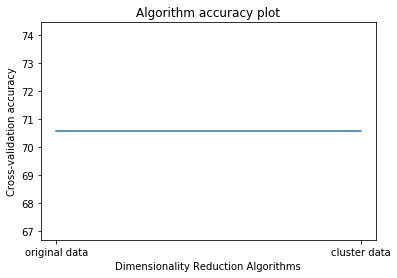

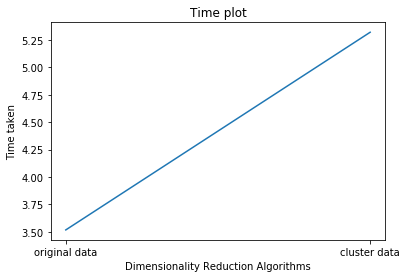

In [109]:
k = KMeans(n_clusters=5, random_state=0).fit_predict(credit_x)
g = GaussianMixture(6, covariance_type='full', random_state=0).fit(credit_x)
g_pred = g.predict_proba(credit_x)
cluster2=pd.DataFrame(g_pred)
cluster2['k']=pd.DataFrame(k)
print('Shape of the Cluster:',cluster2.shape)

clus_xtrain, clus_xtest, clus_ytrain, clus_ytest = test_train_split(cluster2, credit_y)
credit_grid_clus,credit_times_clus,credit_cvacc_clus,credit_train_acc_clus,credit_test_acc_clus = fun2(clus_xtrain,clus_ytrain,clus_xtest,clus_ytest,clus_xtrain.shape[1],1,parameters,3)

x = np.array(["original data","cluster data"])
cv_acc = np.array([credit_cvacc_org,credit_cvacc_clus])
plt.plot(cv_acc)
plt.xticks([0,1],x)
plt.xlabel('Dimensionality Reduction Algorithms')
plt.ylabel('Cross-validation accuracy')
plt.title('Algorithm accuracy plot')
plt.show()

cv_acc = np.array([credit_times_org,credit_times_clus])
plt.plot(cv_acc)
plt.xticks([0,1], x)
plt.xlabel('Dimensionality Reduction Algorithms')
plt.ylabel('Time taken')
plt.title('Time plot')
plt.show()